## Todo:
- Submit jobs to clusters to do formal simulations as follow:
    - Low-dimensional settings (p=100, n=300), consider random and hub dags (both are randomly generated), randomly generated them 10 times, for each time, consider m=100 interventional samples.
    - High-dim settings (p=1000, n=300), as above, could be computationally very expensive, maybe parallel. (for this simulation we use the same method as in real data, and we will use the results as a backup for the real data results: this in some sense means that latent confounder introduced by lasso will not make our method very bad)
    - Maybe fix s_B and vary interventional strength, and fix interventional strength and vary s_B; and show the results.

- Three variable case with all permuatations.
- Latent variable settings: only for low-dimensional case, discard certain percent (10, 20, 30) of the generated non-RC varianbles.

## Done:
- update 'root_cause_discovery_high_dimensional' function to return final root cause score. 
- Change name 'root_cause_discovery_one_subject_all_perm' to 'root_cause_discovery_main' 
- Change the function 'root_cause_discovery_one_subject_all_perm' so that there is no need to decide threshold.
- Address small issues in 'root_cause_discovery_one_subject_all_perm' 
- Change variable names to make them consistency: e.g., X_obs and Xobs 

### This file is used as a test for later formal/extensive simulations

### Generate data by 

X <- mu_x+ BX +error + delta, 

or

X = (I-B)^{-1}* (mu_x + error + delta), 

with different kinds of B.

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import networkx as nx # draw DAG
import warnings  # ignore the warnings
from post_translation_code import  *
from simulation_setting_func import  *

import matplotlib.pyplot as plt
from collections import Counter

def draw_hist(list1, list2, label1, label2, bar_width_para=5):
    # Count the frequency of each integer in the lists
    counter1 = Counter(list1)
    counter2 = Counter(list2)
    
    # Combine keys from both counters
    all_elements = list(set(counter1.keys()).union(set(counter2.keys())))
    all_elements.sort()  # Sort elements for better visualization
    
    # Extract counts, ensuring all_elements order
    counts1 = [counter1[element] for element in all_elements]
    counts2 = [counter2[element] for element in all_elements]

    # Determine the x-axis range and calculate bar width dynamically
    x_range = max(all_elements) - min(all_elements) + 1  # Adding 1 to ensure a non-zero range
    num_elements = len(all_elements)
    bar_width = x_range / (num_elements * bar_width_para)  # Adjust the denominator for desired spacing
    
    # Define the positions of the bars
    r1 = np.arange(len(all_elements))
    r2 = [x + bar_width for x in r1]

    # Create the bar plot
    plt.figure(figsize=(10, 6))
    
    plt.bar(r1, counts1, color='skyblue', width=bar_width, edgecolor='grey', label=label1)
    plt.bar(r2, counts2, color='lightgreen', width=bar_width, edgecolor='grey', label=label2)
    
    # Add labels
    plt.xlabel('Rank of the root cause')
    plt.ylabel('Frequency')
    plt.ylim(0, max(counts1 + counts2)*(1+0.1))

    plt.xticks([r + bar_width/2 for r in range(len(all_elements))], all_elements)
    
    # Set x-axis range
    plt.xlim(min(r1) - bar_width, max(r2) + bar_width)
    
    plt.legend()
    plt.show()

### 1. Random DAG case

In [2]:
np.random.seed(2024)

############## Generate b, B and sigma2_error used in the SEM
p = 50
s_B = 0.3
B_value_min = -1
B_value_max = 1
err_min = 1
err_max = 5
var_X_min = 10
var_X_max = 50
dag_type = "random"

B, sigma2_error, b = generate_setting(dag_type, s_B, B_value_min, B_value_max, err_min, err_max, var_X_min, var_X_max, p)

# G = nx.DiGraph(B!=0)
# nx.draw_kamada_kawai(G, with_labels=False, node_size=25)

### Implement our method based on the simulated data

In [3]:
n = 200
m = 100
int_mean = 15
int_sd = 1

X_obs, X_int_all, RC = generate_data(n, m, p, B, sigma2_error, b, int_mean, int_sd)
print(X_obs.shape, X_int_all.shape)

(200, 50) (100, 50)


In [4]:
Zscores = zscore(X_obs, X_int_all)
#print(np.round(Zscores, 1))
max_index_Zscore = [np.argmax(Zscores[i,:]) for i in range(Zscores.shape[0])]

In [5]:
np.random.seed(1)
RC_scores_chol = np.zeros((X_int_all.shape))
for i, X_int in tqdm(enumerate(X_int_all)):
    # set thresholds based on Zscore[i]
    thresholds = np.arange(0.1, min([5,max(Zscores[i,:])-0.0001]), 0.2)
    
    RC_scores_chol[i,:] = root_cause_discovery_main(X_obs, X_int, thresholds, nshuffles=5, verbose=False)

#print(np.round(RC_scores_chol, 1))
max_index_Chol = [np.argmax(RC_scores_chol[i,:]) for i in range(RC_scores_chol.shape[0])]

100it [02:35,  1.56s/it]


In [6]:
# a quick look at how for how many interventional smaples each method sucessfully find the RC 
num_success_Zscore = sum(x == y for x, y in zip(max_index_Zscore, RC))
num_success_Chol = sum(x == y for x, y in zip(max_index_Chol, RC))
print(num_success_Chol, num_success_Zscore)

# df = pd.DataFrame({"RC":RC, "Zscore": max_index_Zscore, "Chol": max_index_Chol})
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
# print(df.to_string(index=False))

88 52


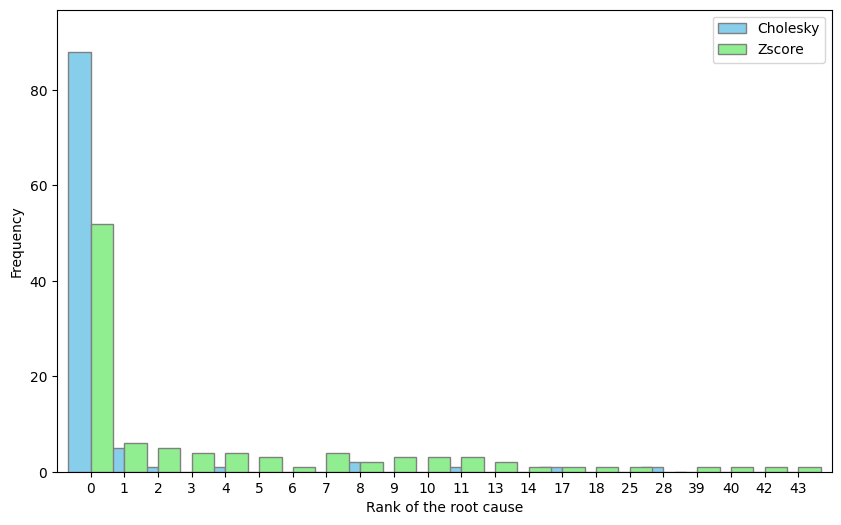

In [7]:
RC_rank_Zscore = [np.sum(Zscores[i,RC[i]] < Zscores[i,:]) 
 for i in range(Zscores.shape[0])]

RC_rank_Chol = [np.sum(RC_scores_chol[i,RC[i]] < RC_scores_chol[i,:]) 
 for i in range(RC_scores_chol.shape[0])]

draw_hist(RC_rank_Chol, RC_rank_Zscore, 'Cholesky', 'Zscore', bar_width_para=3)

### Observations:
- for given small s_B, Chol is much better than Zscore for small int_mean (e.g., int_mean = 10). As int_mean increase (e.g., 100), both methods can find most RCs, because in sparse setting for Zscore the identifiability condition typically holds, and here we simply randomly assign RCs.
- The performance of Zsocre getting worse as s_B getting larger, but not super bad (for int_mean=100. s_B=0.3: 100 91; s_B=0.9: 100 77).

Why Chol can be much better even though we use var_X_min = 20, var_X_max = 40, and int_mean = 10 ? where is the gain from?

#### 2. Hub DAG case: same simulation as above but using another DAG

p is 52


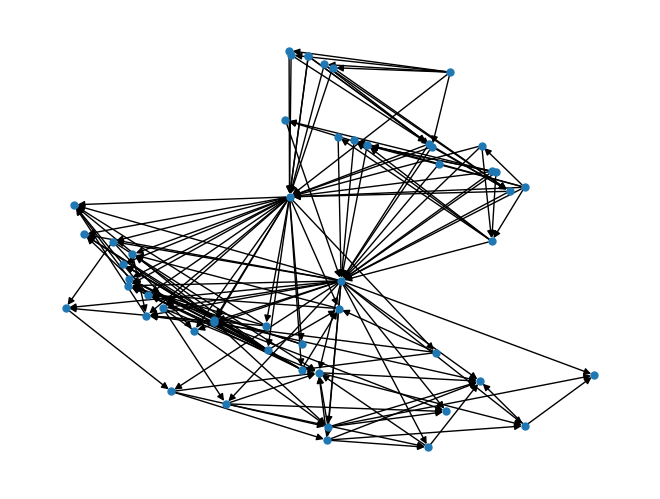

In [2]:
np.random.seed(2024)

### Parameters for B_hub
num_hub = 2 # same number of upper and lower blocks
s_B = 0.3
B_value_min = -1
B_value_max = 1
err_min = 1
err_max = 5
var_X_min = 10
var_X_max = 50

size_up_block = 15
size_low_block = 10
intersect_prop = 0.3

dag_type = "hub"

B, sigma2_error, b = generate_setting(dag_type, s_B, B_value_min, B_value_max, err_min, err_max, var_X_min, var_X_max,
                                      num_hub=num_hub, size_up_block=size_up_block, 
                                      size_low_block=size_low_block, intersect_prop=intersect_prop)
p = len(b)
print(f"p is {p}")

G = nx.DiGraph(B!=0)
nx.draw_kamada_kawai(G, with_labels=False, node_size=25)

In [3]:
n = 200
m = 100
int_mean = 15
int_sd = 1
X_obs, X_int_all, RC = generate_data(n, m, p, B, sigma2_error, b, int_mean, int_sd)
print(X_obs.shape, X_int_all.shape)

(200, 52) (100, 52)


In [4]:
Zscores = zscore(X_obs, X_int_all)
#print(np.round(Zscores, 1))
max_index_Zscore = [np.argmax(Zscores[i,:]) for i in range(Zscores.shape[0])]

In [5]:
RC_scores_chol = np.zeros((X_int_all.shape))
for i, X_int in tqdm(enumerate(X_int_all)):
    thresholds = np.arange(0.1, min([5,max(Zscores[i,:])-0.0001]), 0.2)
    RC_scores_chol[i,:] = root_cause_discovery_main(X_obs, X_int, thresholds, nshuffles=5, verbose=False)

#print(np.round(RC_scores_chol, 1))
max_index_Chol = [np.argmax(RC_scores_chol[i,:]) for i in range(RC_scores_chol.shape[0])]

100it [02:34,  1.55s/it]


In [6]:
# a quick look at how for how many interventional smaples each method sucessfully find the RC 
num_success_Zscore = sum(x == y for x, y in zip(max_index_Zscore, RC))
num_success_Chol = sum(x == y for x, y in zip(max_index_Chol, RC))
print(num_success_Chol, num_success_Zscore)

# df = pd.DataFrame({"RC":RC, "Zscore": max_index_Zscore, "Chol": max_index_Chol})
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
# print(df.to_string(index=False))

84 53


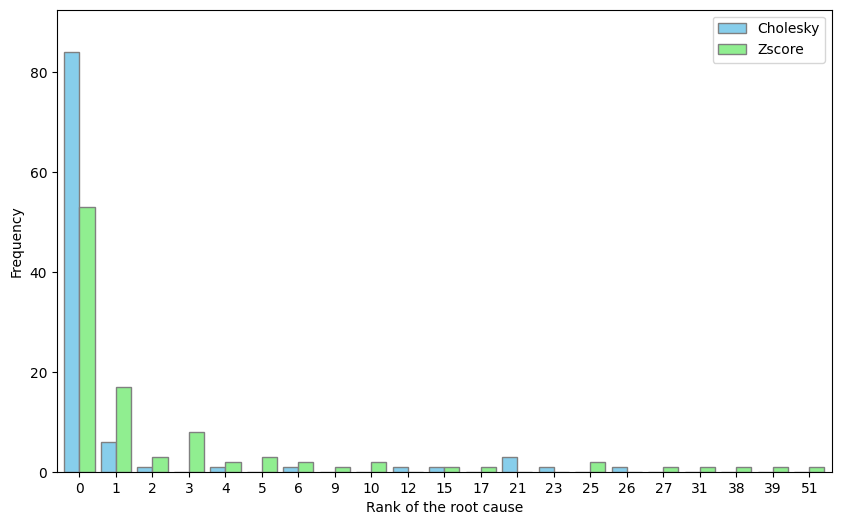

In [7]:
RC_rank_Zscore = [np.sum(Zscores[i,RC[i]] < Zscores[i,:]) 
 for i in range(Zscores.shape[0])]

RC_rank_Chol = [np.sum(RC_scores_chol[i,RC[i]] < RC_scores_chol[i,:]) 
 for i in range(RC_scores_chol.shape[0])]

draw_hist(RC_rank_Chol, RC_rank_Zscore, 'Cholesky', 'Zscore', bar_width_para=6)

### 3. High-dimensional setting

In [22]:
# random DAG
# np.random.seed(2024)

# ############## Generate b, B and sigma2_error used in the SEM
# p = 500
# s_B = 0.03
# B_value_min = -1
# B_value_max = 1
# err_min = 1
# err_max = 5
# var_X_min = 10
# var_X_max = 50
# dag_type = "random"

# B, sigma2_error, b = generate_setting(dag_type, s_B, B_value_min, B_value_max, err_min, err_max, var_X_min, var_X_max, p)

In [2]:
# hub DAG
np.random.seed(2024)

### Parameters for B_hub
num_hub = 10 # same number of upper and lower blocks
s_B = 0.4
B_value_min = -1
B_value_max = 1
err_min = 1
err_max = 5
var_X_min = 10
var_X_max = 50

size_up_block = 30
size_low_block = 20
intersect_prop = 0.3

dag_type = "hub"

B, sigma2_error, b = generate_setting(dag_type, s_B, B_value_min, B_value_max, err_min, err_max, var_X_min, var_X_max,
                                      num_hub=num_hub, size_up_block=size_up_block, 
                                      size_low_block=size_low_block, intersect_prop=intersect_prop)
p = len(b)
print(f"p is {p}")

p is 510


In [3]:
# check the 'sparsity' wrt precision matrix
I = np.eye(p)
Precision_mat = (I - B).T @ np.diag(1/np.diag(sigma2_error)) @ (I - B)
np.sum(Precision_mat != 0 ) / p**2

0.07221068819684737

In [4]:
n = 100
m = 30
int_mean = 15
int_sd = 1

X_obs, X_int_all, RC = generate_data(n, m, p, B, sigma2_error, b, int_mean, int_sd)
print(X_obs.shape, X_int_all.shape)

(100, 510) (30, 510)


In [5]:
# performance of Zscore method
Zscores = zscore(X_obs, X_int_all)
#print(np.round(Zscores, 1))
max_index_Zscore = [np.argmax(Zscores[i,:]) for i in range(Zscores.shape[0])]

num_success_Zscore = sum(x == y for x, y in zip(max_index_Zscore, RC))

RC_rank_Zscore = [np.sum(Zscores[i,RC[i]] < Zscores[i,:]) 
 for i in range(Zscores.shape[0])]

print("m is", m, " Zscore has",num_success_Zscore,"successes")
print(f"{RC_rank_Zscore=}")

m is 30  Zscore has 5 successes
RC_rank_Zscore=[9, 2, 90, 4, 8, 67, 10, 6, 81, 10, 137, 10, 2, 0, 1, 6, 0, 0, 1, 1, 107, 165, 5, 6, 73, 0, 62, 14, 0, 30]


### Try our method for one interventional sample: pick one Zscore is bad

In [6]:
int_sample_idx = 2

X_int = X_int_all[int_sample_idx,:]
method = "largest_support"
verbose = False
nshuffles = 5

y_idx_z_threshold = 1.5    # this can also be put in a for loop? or make it very small? Check whether real data still good with this to be 0

z = zscore(X_obs, X_int)
y_indices = np.where(z > y_idx_z_threshold)[0]

print(f"{len(y_indices)=}")

if RC[int_sample_idx] in y_indices:
    print("RC is in y_indices")

print(f"{z[RC[int_sample_idx]]=}")

len(y_indices)=145
RC is in y_indices
z[RC[int_sample_idx]]=2.350100129014883


In [7]:
# run partial procedure to check whether we found a match when treating the true RC as response
y_idx = RC[int_sample_idx]

X_obs_new, X_int_sample_new, selected_idx = reduce_dimension(y_idx, X_obs, X_int, method, verbose)

z_new = zscore(X_obs_new, X_int_sample_new)

thresholds = np.arange(0.1, min([5,max(z_new)-0.0001]), 0.2)

best_Xtilde = 0
best_OneNonZero_quantification = 0
for threshold in thresholds:
    # compute permutations to try
    permutations = compute_permutations(z_new, threshold=threshold, nshuffles=nshuffles)
    if verbose:
        print("Trying", len(permutations), "permutations for threshold", threshold)

    # try all permutations to calculate 'Xtilde'
    for perm in permutations:
        Xtilde = root_cause_discovery(X_obs_new, X_int_sample_new, perm)
        sorted_X = sorted(Xtilde)
        OneNonZero_quantification = (sorted_X[-1] - sorted_X[-2]) / sorted_X[-2]
        
        if z_new[np.argmax(Xtilde)] > y_idx_z_threshold and OneNonZero_quantification > best_OneNonZero_quantification:
            best_Xtilde = Xtilde
            best_OneNonZero_quantification = OneNonZero_quantification
if max(best_Xtilde) == best_Xtilde[-1]:
    print("match")

match


In [8]:
# run our method using oracle MD based on 'Precision_mat' (error is Gaussian so we can do this)
# This is to check the performence when MD can be well-estimated (try simulatio using large int_mean)

root_cause_score2 = np.zeros(p)
for y_idx in tqdm(y_indices):
    MB = np.where(Precision_mat[:, y_idx] != 0 )[0]
    MB = np.delete(MB, np.where(MB == y_idx)[0][0])
    MB = np.append(MB, y_idx) # put y_idx in the end
    X_obs_new = X_obs[:, MB]
    X_int_sample_new = X_int[MB]
    
    z_new = zscore(X_obs_new, X_int_sample_new)
    
    thresholds = np.arange(0.1, min([5, max(z_new)-0.0001]), 0.2)
    best_Xtilde = 0
    best_OneNonZero_quantification = 0
    for threshold in thresholds:
        # compute permutations to try
        permutations = compute_permutations(z_new, threshold=threshold, nshuffles=nshuffles)
        if verbose:
            print("Trying", len(permutations), "permutations for threshold", threshold)
    
        # try all permutations to calculate 'Xtilde'
        for perm in permutations:
            Xtilde = root_cause_discovery(X_obs_new, X_int_sample_new, perm)
            sorted_X = sorted(Xtilde)
            OneNonZero_quantification = (sorted_X[-1] - sorted_X[-2]) / sorted_X[-2]
            
            if z_new[np.argmax(Xtilde)] > y_idx_z_threshold and OneNonZero_quantification > best_OneNonZero_quantification:
                best_Xtilde = Xtilde
                best_OneNonZero_quantification = OneNonZero_quantification

    if not isinstance(best_Xtilde, int):
        if max(best_Xtilde) == best_Xtilde[-1]: # if match y_idx 
            root_cause_score2[y_idx] = best_OneNonZero_quantification

# assign final root cause score for variables that never had maximal Xtilde_i
idx2 = np.where(root_cause_score2 == 0)[0]
if len(idx2) != 0:
    idx1 = np.where(root_cause_score2 != 0)[0]
    max_RC_score_idx2 = np.min(root_cause_score2[idx1]) - 0.0001
    root_cause_score2[idx2] = z[idx2] / (np.max(z[idx2]) / max_RC_score_idx2)

100%|█████████████████████████████████████████| 145/145 [02:58<00:00,  1.23s/it]


In [9]:
# rank of the true RC using root_cause_score2 with oracle MB
print("Rank of RC using zScore is", np.sum(z>z[RC[int_sample_idx]]))
print("Rank of RC using CholScore is", np.sum(root_cause_score2 > np.round(root_cause_score2)[RC[int_sample_idx]]))

Rank of RC using zScore is 90
Rank of RC using CholScore is 2


In [10]:
# run standard procedure for one interventional sample using estimated MB by Lasso, can be computationally expensive!
# the difference performances compared to above is due to the estimated MB (lasso largest-support)

root_cause_score = np.zeros(p)
for y_idx in tqdm(y_indices):
    X_obs_new, X_int_sample_new, selected_idx = reduce_dimension(y_idx, X_obs, X_int, method, verbose)
    
    z_new = zscore(X_obs_new, X_int_sample_new)

    thresholds = np.arange(0.1, min([5, max(z_new)-0.0001]), 0.2)
    
    best_Xtilde = 0
    best_OneNonZero_quantification = 0
    for threshold in thresholds:
        # compute permutations to try
        permutations = compute_permutations(z_new, threshold=threshold, nshuffles=nshuffles)
        if verbose:
            print("Trying", len(permutations), "permutations for threshold", threshold)
    
        # try all permutations to calculate 'Xtilde'
        for perm in permutations:
            Xtilde = root_cause_discovery(X_obs_new, X_int_sample_new, perm)
            sorted_X = sorted(Xtilde)
            OneNonZero_quantification = (sorted_X[-1] - sorted_X[-2]) / sorted_X[-2]
            
            if z_new[np.argmax(Xtilde)] > y_idx_z_threshold and OneNonZero_quantification > best_OneNonZero_quantification:
                best_Xtilde = Xtilde
                best_OneNonZero_quantification = OneNonZero_quantification

    if not isinstance(best_Xtilde, int):
        if max(best_Xtilde) == best_Xtilde[-1]: # if match y_idx 
            root_cause_score[y_idx] = best_OneNonZero_quantification

# assign final root cause score for variables that never had maximal Xtilde_i
idx2 = np.where(root_cause_score == 0)[0]
if len(idx2) != 0:
    idx1 = np.where(root_cause_score != 0)[0]
    max_RC_score_idx2 = np.min(root_cause_score[idx1]) - 0.0001
    root_cause_score[idx2] = z[idx2] / (np.max(z[idx2]) / max_RC_score_idx2)

100%|█████████████████████████████████████████| 145/145 [24:16<00:00, 10.05s/it]


In [11]:
# rank of the true RC using root_cause_score
print("Rank of RC using zScore is", np.sum(z>z[RC[int_sample_idx]]))
print("Rank of RC using CholScore is", np.sum(root_cause_score > np.round(root_cause_score)[RC[int_sample_idx]]))

Rank of RC using zScore is 90
Rank of RC using CholScore is 6


In [ ]:
# sometimes the performance using estimated MB is better than using the true MB...